# Layer-wise Activation Cluster Analysis (LACA) - Eval OoD-Detection on FGSM (SVHN)

#### Model
The SVHN model was trained using the training setup that has also been used by Papernot and McDaniel. For more details see their [paper](https://arxiv.org/abs/1803.04765) and their [sample code](https://github.com/cleverhans-lab/cleverhans/blob/master/cleverhans/model_zoo/deep_k_nearest_neighbors/dknn.py).

#### Approach
1. Fetch Activations from each layer
2. Convert layer activations to a vector:
    - linear layer activations are already in vector form
    - conv layer activations are flattened (this was also used by Papernot and McDaniel)
3. Create projections for each layer:
    - scale activations
    - reduce activations to 2D using PCA (to 50D) and then UMAP (to 2D) (if there are less than 50D only UMAP is used; similar approach was also used by [Ngyuen et. al.](https://arxiv.org/abs/1602.03616), but we use UMAP instead of t-SNE here because UMAP is parametric)
4. Find clusters from projections:
    - cluster projections using k-Means (use silhouette score to pick k, but we use values around k = #classes)
    - use the silhouette score to evaluate cluster result (this was also used by Chen et. al., see their [paper](https://arxiv.org/abs/1811.03728) published at an [AAAI Workshop](http://ceur-ws.org/Vol-2301/)) 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# BUG FIX, see: https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Load libs
import torch
import torch.nn as nn
from torch.nn.functional import adaptive_avg_pool2d
import torchvision
from torchvision import transforms
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import skimage
from skimage.measure import block_reduce
from umap import UMAP
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import platform
import warnings
import pprint
from collections import Counter

sns.set()
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('sklearn version:     {}'.format(sklearn.__version__))
print('skimage version:     {}'.format(skimage.__version__))
print('numpy version:       {}'.format(np.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('seaborn version:     {}'.format(sns.__version__))
print('pandas version:      {}'.format(pd.__version__))
print('pickle version:      {}'.format(pickle.format_version))

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))
    
if use_cuda:
    print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:      3.6.9
torch version:       1.7.0
torchvision version: 0.8.1
sklearn version:     0.23.2
skimage version:     0.17.2
numpy version:       1.19.5
matplotlib version:  3.2.2
seaborn version:     0.11.0
pandas version:      1.1.4
pickle version:      4.0
CUDA available:      False
cuDNN enabled:       True
num gpus:            0


Put CUDNN to deterministic and set seed values for [reproducibility reasons](https://pytorch.org/docs/stable/notes/randomness.html).

In [2]:
random_seed = 0
torch.manual_seed(random_seed)
np.random.seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_deterministic(True)

Let's set some parameters for the Deep kNN.

In [3]:
batch_size_train = 500    # batch size for training
batch_size_test = 1000    # batch size for testing

## Data

### Specify Dataset

In [4]:
class CustomTensorDataset(torch.utils.data.Dataset):
    """
    TensorDataset with support for transforms
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

Define data transform functions for training and test set.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Define training and test set.

In [6]:
# Training set
trainset = torchvision.datasets.SVHN(
    root='./data', split='train', download=True, transform=transform
)

Using downloaded and verified file: ./data/train_32x32.mat


### Load Data

Create train, test and calibration data loader.

In [7]:
# Create training data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=False, num_workers=2
)

# Create test data loader
fname = '/Users/lehmann/research/laca/adv_examples/advloader_svhn_fgsm.pth'
testloader = torch.load(fname)

Print out the sizes of the datasets.

In [8]:
print('trainset size: {}'.format(len(trainloader.dataset)))
print('testset size:  {}'.format(len(testloader.dataset)))

trainset size: 73257
testset size:  26032


### Display Samples

In [9]:
def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        
        img = np.moveaxis(data[i], 0, -1)
        img = img * 0.5 + 0.5  # unnormalize
        plt.imshow(img)
        plt.title("Ground Truth: {}".format(targets[i]))
        
        plt.xticks([])
        plt.yticks([])

Load a few test images and display them.

tensor shape: (1000, 3, 32, 32)


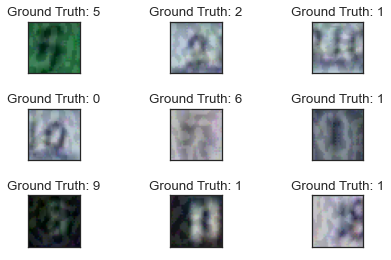

In [10]:
dataiter = enumerate(testloader)
_, (sample_data, sample_targets) = next(dataiter)

show_samples(sample_data, sample_targets)

## Define Test Functions

Let's define the function for testing.

In [11]:
def test(model, crit, data_loader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in data_loader:
            # Get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            
            # Forward + loss + correct
            outputs = model(inputs)
            test_loss += crit(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(data_loader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

## Network Architecture

Let's define the neural network based model architecture for MNIST.

In [12]:
class SvhnNet(nn.Module):
    def __init__(self):
        super(SvhnNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=8, stride=2, padding=3)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=6, stride=2)
        self.relu2 = nn.ReLU(True)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5)
        self.relu3 = nn.ReLU(True)
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

## Model Testing

Let's load the model.

In [13]:
# Create Model
model = SvhnNet()
criterion = nn.CrossEntropyLoss()

# Load Model
model.load_state_dict(torch.load("/Users/lehmann/research/laca/models/svhn_model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

Put model in evaluation mode.

In [14]:
model.eval()

if use_cuda:
    model.cuda()
    print('Using ', torch.cuda.device_count(), ' GPU(s)')

Let's test the model.

In [15]:
def test_final(model, data_loader):
    _, accs = test(model, criterion, data_loader, [], [])
    return accs[0]

In [16]:
test_acc = test_final(model, testloader); test_acc


Test set: Avg. loss: 0.009018, Accuracy: 707/26032 (2.72%)



2.7158881376767057

## Fetch Activations

Let's fetch the activations from each layer (when feeding the trained model with images). To see again which layers we have let's print the model architecture.

In [17]:
model

SvhnNet(
  (conv1): Conv2d(3, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(6, 6), stride=(2, 2))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Specify layers to be used.

In [18]:
layers = {
    'relu1': {'layer': model.relu1},
    'relu2': {'layer': model.relu2},
    'relu3': {'layer': model.relu3},
    'fc':    {'layer': model.fc}
}

Define function to fetch activations.

In [19]:
def fetch_activations(dataloader, model, layers):    
    activations = {}
    activations['activations'] = {}
    activations['targets'] = None

    for layer_name in layers:
        print('## Fetching Activations from Layer {}'.format(layer_name))

        # Fetch activations for the data
        layer = layers[layer_name]
        layer_activations, layer_targets = fetch_activations_from_layer(dataloader, model, layer)
        print('- activations fetched: {}'.format(layer_activations.shape))
        
        # Save activations
        activations['activations'][layer_name] = layer_activations

        # Get the targets of that data
        if layer_targets is not None:
            if activations['targets'] is not None:
                np.testing.assert_array_equal(activations['targets'], layer_targets)
            else:
                activations['targets'] = layer_targets

        print("done!")        
        print()

    return activations

def fetch_activations_from_layer(dataloader, model, layer):
    activations = []
    targets = []

    # Define hook for fetching the activations
    def hook(module, input, output):
        layer_activations = output.squeeze().detach().cpu()
        activations.append(layer_activations)

    handle = layer['layer'].register_forward_hook(hook)

    # Fetch activations
    for i, batch in enumerate(dataloader):
        print('Processing Batch {}'.format(i))

        if use_cuda:
            batch = batch.cuda()
            
        _ = model(batch[0])

        if len(batch) > 1:
            targets.append(batch[1].detach().cpu().numpy())

    # Remove hook
    handle.remove()

    # Return activations and targets
    activations = np.concatenate(activations)

    if targets:
        targets = np.hstack(targets)
    else:
        None

    return activations, targets

Fetch activations for each layer.

In [20]:
activations = fetch_activations(testloader, model, layers)

## Fetching Activations from Layer relu1
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
Processing Batch 10
Processing Batch 11
Processing Batch 12
Processing Batch 13
Processing Batch 14
Processing Batch 15
Processing Batch 16
Processing Batch 17
Processing Batch 18
Processing Batch 19
Processing Batch 20
Processing Batch 21
Processing Batch 22
Processing Batch 23
Processing Batch 24
Processing Batch 25
Processing Batch 26
- activations fetched: (26032, 64, 16, 16)
done!

## Fetching Activations from Layer relu2
Processing Batch 0
Processing Batch 1
Processing Batch 2
Processing Batch 3
Processing Batch 4
Processing Batch 5
Processing Batch 6
Processing Batch 7
Processing Batch 8
Processing Batch 9
Processing Batch 10
Processing Batch 11
Processing Batch 12
Processing Batch 13
Processing Batch 14
Processing Batch 15
Processing Batch 16
Processi

In [21]:
print('targets: {}'.format(activations['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('activations: {}'.format(activations['activations'][layer].shape))
    print()

targets: (26032,)

## layer relu1
activations: (26032, 64, 16, 16)

## layer relu2
activations: (26032, 128, 6, 6)

## layer relu3
activations: (26032, 128, 2, 2)

## layer fc
activations: (26032, 10)



In [22]:
#fname = '/Users/lehmann/research/laca/exp4/laca_svhn_exp4_activations.pkl'
#with open(fname, 'wb') as pickle_file:
#    pickle.dump(activations, pickle_file)

In [23]:
#with open(fname, 'rb') as pickle_file:
#    loaded_activations = pickle.load(pickle_file)

In [24]:
#print('targets: {}'.format(loaded_activations['targets'].shape))
#print()
#
#for layer in layers:
#    print('## layer {}'.format(layer))
#    print('activations: {}'.format(loaded_activations['activations'][layer].shape))
#    print()

## Transform Activations to Vectors

Now, we want to transform the activations into vector form. Let's define the function to transform activations to vector form.

In [25]:
def transform_acts2vec(activations, pool=None):
    activation_vectors = {}
    activation_vectors['activations'] = {}
    activation_vectors['targets'] = None
    
    layers = list(activations['activations'].keys())
    
    for layer_name in layers:
        print('## Transforming Activations to Vector Form for Layer {}'.format(layer_name))
        
        # Transform activations
        layer_activations = activations['activations'][layer_name]
        layer_activation_vectors = []
        
        for i in range(layer_activations.shape[0]):
            sample_activation_vector = transform_acts2vec_from_sample(layer_activations[i], pool)            
            layer_activation_vectors.append(sample_activation_vector)
                        
        layer_activation_vectors = np.array(layer_activation_vectors)    
        print('- activations transformed: {}'.format(layer_activation_vectors.shape))
        
        # Save activations vectors
        activation_vectors['activations'][layer_name] = layer_activation_vectors
        
        # Copy targets
        activation_vectors['targets'] = activations['targets']

        print("done!")        
        print()
    
    return activation_vectors


def transform_acts2vec_from_sample(sample_activations, pool=(2,2)):
    if len(sample_activations.shape) == 3:
        if pool is None:
            sample_activations = sample_activations.flatten()
        else:
            sample_activations = np.array([
                block_reduce(act_map, pool, np.mean) for act_map in sample_activations
            ]).flatten()
                        
    return sample_activations

Transform activations.

In [26]:
activation_vectors = transform_acts2vec(activations, None)

## Transforming Activations to Vector Form for Layer relu1
- activations transformed: (26032, 16384)
done!

## Transforming Activations to Vector Form for Layer relu2
- activations transformed: (26032, 4608)
done!

## Transforming Activations to Vector Form for Layer relu3
- activations transformed: (26032, 512)
done!

## Transforming Activations to Vector Form for Layer fc
- activations transformed: (26032, 10)
done!



In [27]:
print('targets: {}'.format(activation_vectors['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('activations: {}'.format(activation_vectors['activations'][layer].shape))
    print()

targets: (26032,)

## layer relu1
activations: (26032, 16384)

## layer relu2
activations: (26032, 4608)

## layer relu3
activations: (26032, 512)

## layer fc
activations: (26032, 10)



In [28]:
#fname = '/Users/lehmann/research/laca/exp4/laca_svhn_exp4_activation_vectors.pkl'
#with open(fname, 'wb') as pickle_file:
#    pickle.dump(activation_vectors, pickle_file)

In [29]:
#with open(fname, 'rb') as pickle_file:
#    loaded_activation_vectors = pickle.load(pickle_file)

In [30]:
#print('targets: {}'.format(loaded_activation_vectors['targets'].shape))
#print()
#
#for layer in layers:
#    print('## layer {}'.format(layer))
#    print('activations: {}'.format(loaded_activation_vectors['activations'][layer].shape))
#    print()

## Get Projections

Let's get the projections of each layer. Projections are the activations of the layers (we need them in the vector form for this) reduced to 2D.

Define function to get projections.

In [31]:
def get_projections(activation_vectors, ext_scaler, ext_reducer):
    if ext_reducer:
        print('## external reducer is used')
        print()
        print()
    
    projections = {}
    projections['projections'] = {}
    projections['targets'] = None
    projections['scaler'] = {}
    projections['reducer'] = {}
    
    layers = list(activation_vectors['activations'].keys())

    for layer_name in layers:
        print('## Computing Projections for Layer {}'.format(layer_name))
        
        # Normalize activations
        layer_activations = activation_vectors['activations'][layer_name]    
        layer_activations_norm = ext_scaler[layer_name].transform(layer_activations)
        
        print('- activations normalized: {}'.format(layer_activations_norm.shape))
        
        # Reduce activations
        proj_temp = layer_activations_norm
        for r in ext_reducer[layer_name]:
            proj_temp = r.transform(proj_temp)
        layer_projections = proj_temp
            
        print('- activations reduced: {}'.format(layer_projections.shape))
        
        # Save projections and reducer
        projections['projections'][layer_name] = layer_projections
        projections['reducer'][layer_name] = ext_reducer[layer_name]
        projections['scaler'][layer_name] = ext_scaler[layer_name]

        # Copy targets
        projections['targets'] = activation_vectors['targets'] 

        print("done!")        
        print()

    return projections

Get the projections for each layer. Also save the scaler and the reducer (reduces activations to 2D), so that it can be reused for new data.

In [32]:
fname = '/Users/lehmann/research/laca/exp1/exp1_0/laca_svhn_baseline_projections.pkl'
#with open(fname, 'wb') as pickle_file:
#    pickle.dump(projections, pickle_file)

In [33]:
with open(fname, 'rb') as pickle_file:
    loaded_baseline_projections = pickle.load(pickle_file)

In [34]:
def plot_projects(projections, cluster_labels=None, cluster_centers=None):
    layers = list(projections['projections'].keys())
    
    for layer_name in layers:        
        df = pd.DataFrame()
        df['x'] = projections['projections'][layer_name][:,0]
        df['y'] = projections['projections'][layer_name][:,1]
        
        if cluster_labels is not None:
            df['targets'] = cluster_labels[layer_name]
        else:
            df['targets'] = projections['targets']
    
        plot = sns.lmplot(
            x='x', y='y', data=df, fit_reg=False, hue='targets', height=8, palette='muted', legend=False,
            scatter_kws={'marker': 'D', 's': 50, 'alpha': 0.6}
        ).set_axis_labels('x1','x2')
    
        if cluster_labels is not None:
            plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        else:
            plt.legend(title='Object Class', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
        if cluster_centers is not None:
            plt.plot(*zip(*cluster_centers[layer_name]), marker='x', color='black', ls='', markersize=14, markeredgewidth=2)
    
        fig = plot.fig
        fig.suptitle('Projections from Layer {}'.format(layer_name), y=1.025, fontsize = 20)

In [35]:
print('targets: {}'.format(loaded_baseline_projections['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('projections: {}'.format(loaded_baseline_projections['projections'][layer].shape))
    print('scaler:      {}'.format(loaded_baseline_projections['scaler'][layer]))
    print('reducer:     {}'.format(loaded_baseline_projections['reducer'][layer]))
    print()

targets: (73257,)

## layer relu1
projections: (73257, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer relu2
projections: (73257, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer relu3
projections: (73257, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer fc
projections: (73257, 2)
scaler:      StandardScaler()
reducer:     [UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]



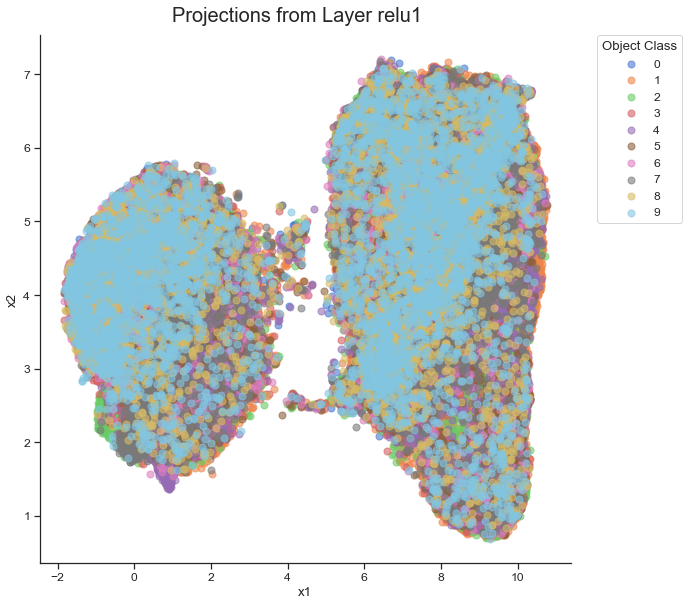

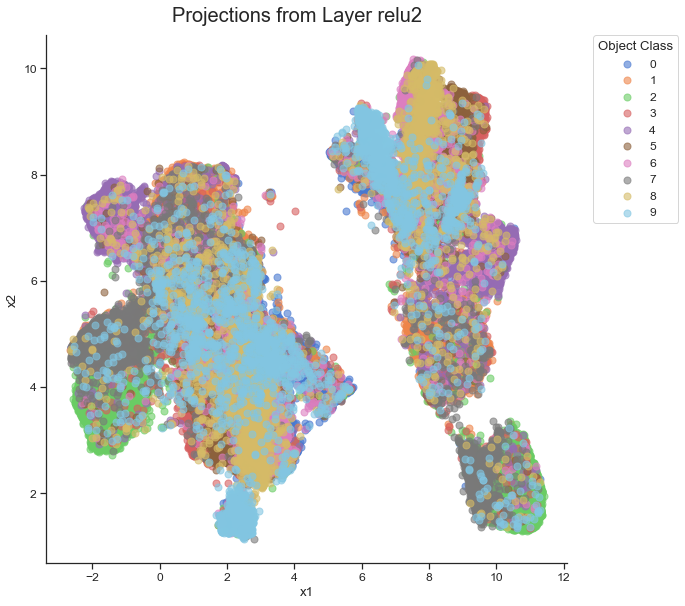

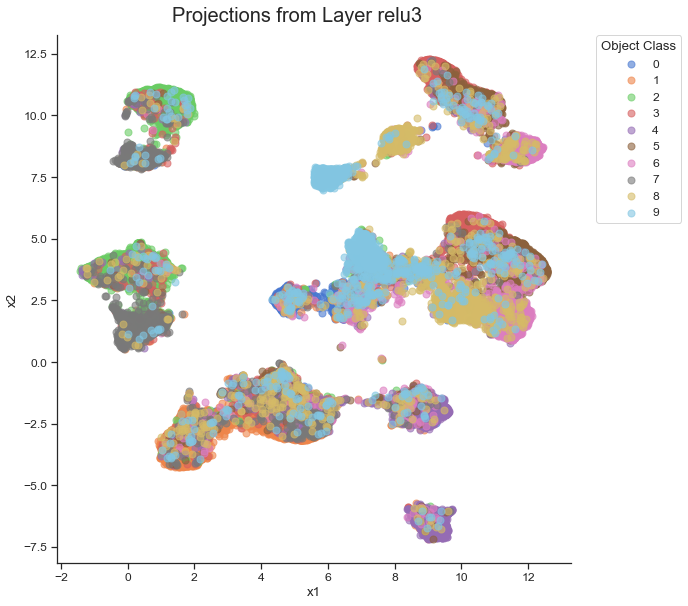

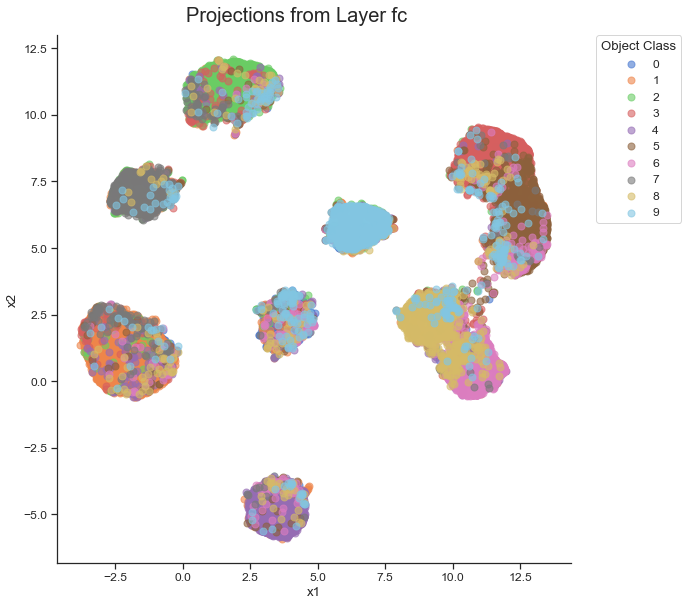

In [36]:
plot_projects(loaded_baseline_projections)

In [37]:
projections = get_projections(activation_vectors, ext_scaler=loaded_baseline_projections['scaler'], ext_reducer=loaded_baseline_projections['reducer'])

## external reducer is used


## Computing Projections for Layer relu1
- activations normalized: (26032, 16384)
- activations reduced: (26032, 2)
done!

## Computing Projections for Layer relu2
- activations normalized: (26032, 4608)
- activations reduced: (26032, 2)
done!

## Computing Projections for Layer relu3
- activations normalized: (26032, 512)
- activations reduced: (26032, 2)
done!

## Computing Projections for Layer fc
- activations normalized: (26032, 10)
- activations reduced: (26032, 2)
done!



In [38]:
print('targets: {}'.format(projections['targets'].shape))
print()

for layer in layers:
    print('## layer {}'.format(layer))
    print('projections: {}'.format(projections['projections'][layer].shape))
    print('scaler:      {}'.format(projections['scaler'][layer]))
    print('reducer:     {}'.format(projections['reducer'][layer]))
    print()

targets: (26032,)

## layer relu1
projections: (26032, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer relu2
projections: (26032, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer relu3
projections: (26032, 2)
scaler:      StandardScaler()
reducer:     [PCA(n_components=50), UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]

## layer fc
projections: (26032, 2)
scaler:      StandardScaler()
reducer:     [UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.0)]



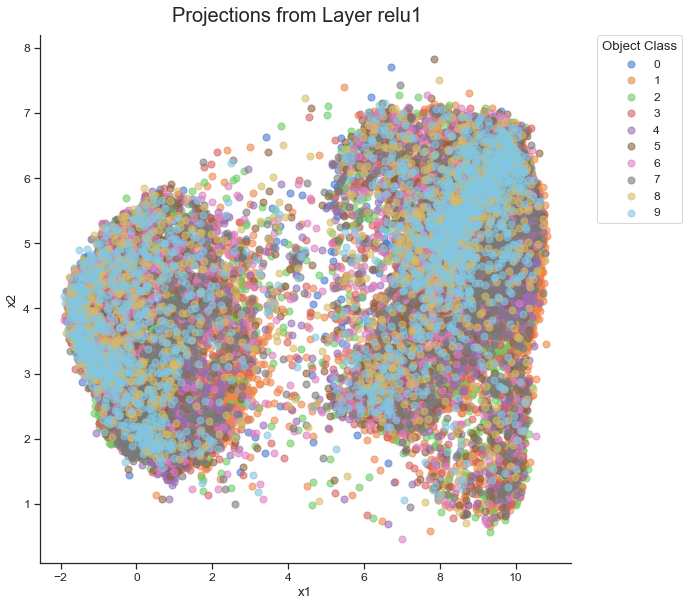

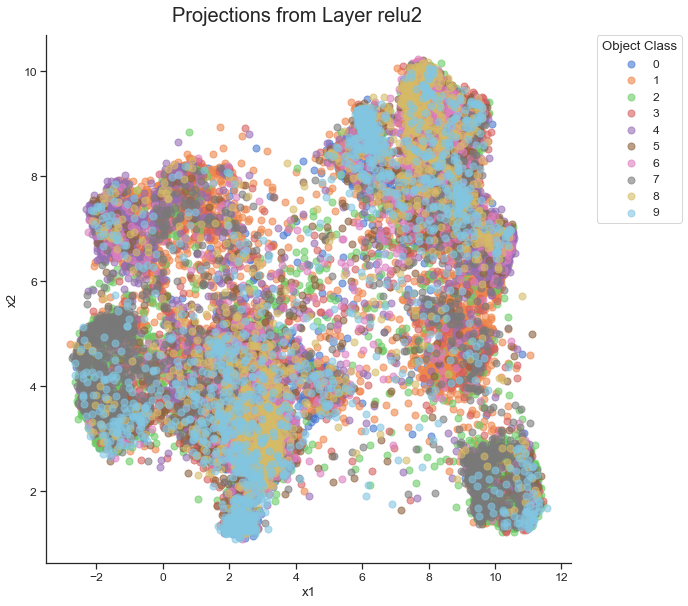

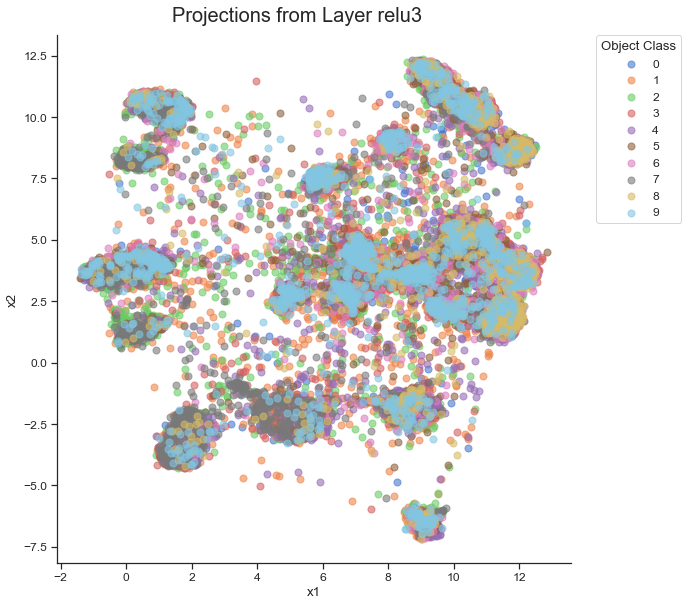

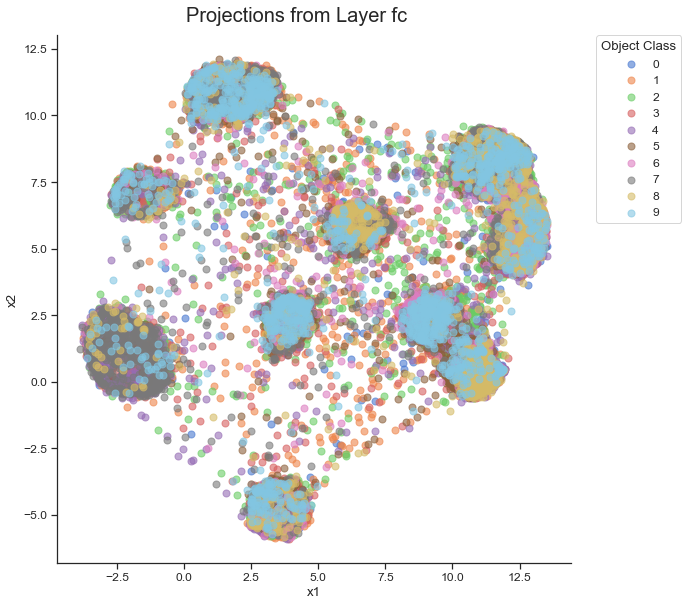

In [39]:
plot_projects(projections)

## Get Clusters

Now, we want to find clusters in the projection of each layer. Let's define the cluster function.

In [40]:
def get_kmeans_clusters(projections, k_params):
    clusters = {}
    clusters['cluster_labels'] = {}
    clusters['cluster_centers'] = {}
    clusters['clusterer'] = {}
    clusters['eval'] = {}
    clusters['stats'] = {}
    
    sh_scores = []
    
    for layer_name in layers:
        print('## Computing Projections for Layer {}'.format(layer_name))
        
        # Get clusters
        projects = projections['projections'][layer_name]
        
        best_sh_score = None
        best_clusterer = None
        
        for k in k_params:
            clusterer = KMeans(init='k-means++', n_clusters=k, n_init=10)
            clusterer.fit(projects)
            
            temp_sh_score = metrics.silhouette_score(projects, clusterer.labels_, metric='euclidean')
            
            if best_sh_score is None:
                best_sh_score = temp_sh_score
                best_clusterer = clusterer
            elif best_sh_score < temp_sh_score:
                best_sh_score = temp_sh_score
                best_clusterer = clusterer
        
        # Calculate cluster stats
        labels = best_clusterer.labels_
        targets = projections['targets']
        
        cluster_classes = dict([(i,[]) for i in np.unique(labels)])
        for i in range(len(labels)):
            cluster_classes[labels[i]].append(targets[i])
            
        for label in cluster_classes:
            total = len(cluster_classes[label])
            counts = dict(Counter(cluster_classes[label]))
            for c in counts:
                counts[c] /= total
            cluster_classes[label] = counts  
        
        # Save cluster result       
        clusters['cluster_labels'][layer_name] = best_clusterer.labels_
        clusters['cluster_centers'][layer_name] = best_clusterer.cluster_centers_
        clusters['clusterer'][layer_name] = best_clusterer
        clusters['eval'][layer_name] = best_sh_score
        clusters['stats'][layer_name] = cluster_classes
        
        sh_scores.append(best_sh_score)

        print('- clusters computed, Silhouette: {}'.format(best_sh_score))
        print()
    
    print()
    print('Total Silhouette: {}'.format(np.median(np.array(sh_scores))))
          
    return clusters

Let's use k-Means clustering (with K = Number of Classes) to compute the clusters for the projections of each layer.

In [41]:
fname = '/Users/lehmann/research/laca/exp1/exp1_0/laca_svhn_baseline_clusters.pkl'
#with open(fname, 'wb') as pickle_file:
#    pickle.dump(clusters, pickle_file)

In [42]:
with open(fname, 'rb') as pickle_file:
    loaded_baseline_clusters = pickle.load(pickle_file)

In [43]:
for layer in layers:
    print('## layer {}'.format(layer))
    print('cluster labels:  {}'.format(loaded_baseline_clusters['cluster_labels'][layer].shape))
    print('cluster centers: {}'.format(loaded_baseline_clusters['cluster_centers'][layer].shape))
    print('clusterer:       {}'.format(loaded_baseline_clusters['clusterer'][layer]))
    print()

## layer relu1
cluster labels:  (73257,)
cluster centers: (7, 2)
clusterer:       KMeans(n_clusters=7)

## layer relu2
cluster labels:  (73257,)
cluster centers: (5, 2)
clusterer:       KMeans(n_clusters=5)

## layer relu3
cluster labels:  (73257,)
cluster centers: (12, 2)
clusterer:       KMeans(n_clusters=12)

## layer fc
cluster labels:  (73257,)
cluster centers: (10, 2)
clusterer:       KMeans(n_clusters=10)



In [44]:
pprint.pprint(loaded_baseline_clusters['stats'])

{'fc': {0: {0: 0.0031231700175678315,
            1: 0.008393519422213547,
            2: 0.01073589693538942,
            3: 0.02439976576224868,
            4: 0.008003123170017569,
            5: 0.013468670700761272,
            6: 0.026742143275424558,
            7: 0.0011711887565879367,
            8: 0.8928362287722038,
            9: 0.0111262931875854},
        1: {0: 0.005158817893728351,
            1: 0.9626354189697104,
            2: 0.0038322647210553467,
            3: 0.006190581472474021,
            4: 0.006337976269437689,
            5: 0.0021372245559731743,
            6: 0.0024320141499005084,
            7: 0.006853858058810524,
            8: 0.003021593337755177,
            9: 0.0014002505711548383},
        2: {0: 0.001430615164520744,
            1: 0.007439198855507869,
            2: 0.9611826418693371,
            3: 0.009918931807343824,
            4: 0.0031473533619456365,
            5: 0.001430615164520744,
            6: 0.0010491177873152122,
 

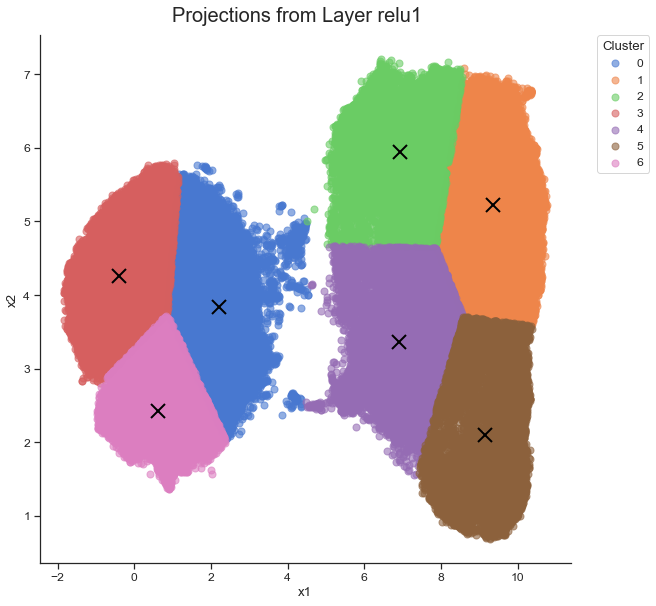

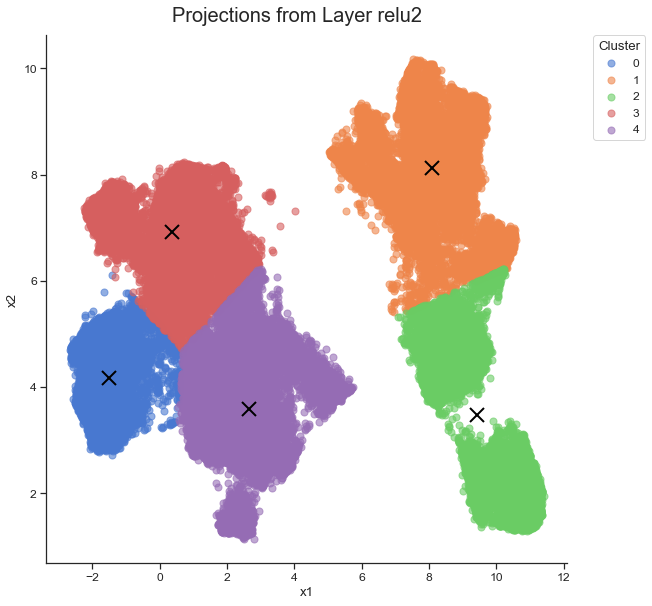

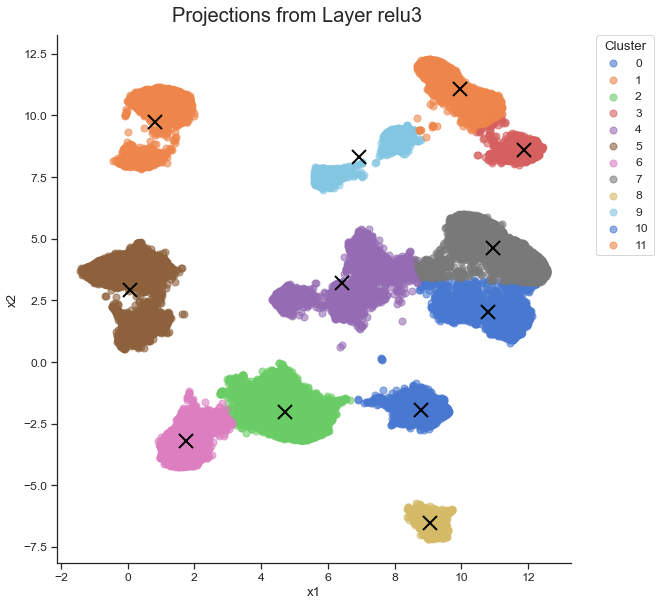

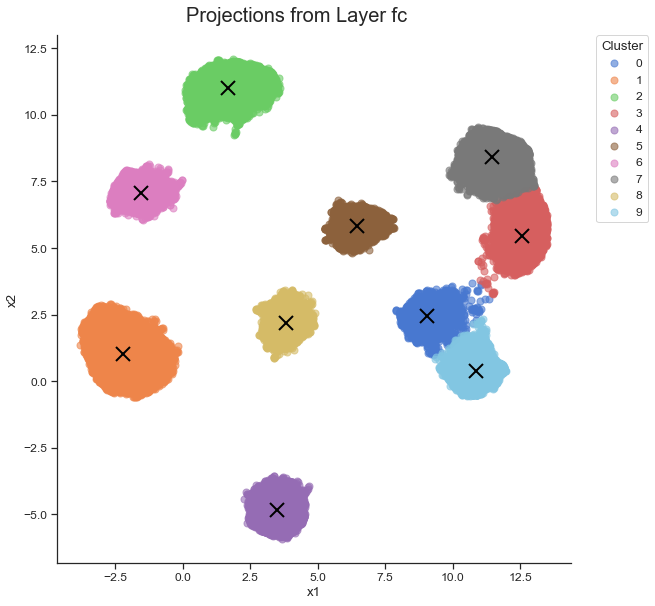

In [45]:
plot_projects(loaded_baseline_projections, loaded_baseline_clusters['cluster_labels'], loaded_baseline_clusters['cluster_centers'])

## Check Samples

Let's check the samples from the test data to see if they are similar to the training set.

In [46]:
def check_samples(clusterer, stats, projections, thresh=0.1):    
    
    # Get cluster label for each test sample
    labels = {}
    for layer_name in layers:
        labels[layer_name] = clusterer[layer_name].predict(projections['projections'][layer_name])
        
    num_samples = len(projections['targets'])
    result = [np.array([-1])]*num_samples

    # Go through all layers
    for layer_name in layers:
        
        # Go through all samples
        for i in range(num_samples):
            
            # Get cluster label from sample
            label = labels[layer_name][i]
            
            # Get stats for that cluster
            layer_target_stats = stats[layer_name][label]
            
            # Only consider classes in cluster which occurence in the cluster is > thresh
            layer_target_stats = {k: v for k, v in layer_target_stats.items() if v > thresh}
            layer_target_stats = np.array(list(layer_target_stats.keys()))
            
            # Check for each sample in result if we already put classes inside from cluster of the first layer
            # (otherwise it is only -1 inside, a value != any cluster id)
            # if it is the first layer than we put the classes of the detected cluster inside that a higher 
            # than thresh
            # if it is not the first cluster then we use intersection of current classes with the classes of 
            # the current cluster
            # result: for each sample the common classes among all layers
            if np.sum(result[i]) == -1:
                result[i] = layer_target_stats
            else:
                result[i] = np.intersect1d(result[i], layer_target_stats)
     
    scores = np.array([0]*num_samples)
    for i in range(num_samples):
        scores[i] = result[i].size != 0
        
    return np.sum(scores) / num_samples

In [47]:
indist_score01 = check_samples(loaded_baseline_clusters['clusterer'], loaded_baseline_clusters['stats'], projections, 0.1)
indist_score005 = check_samples(loaded_baseline_clusters['clusterer'], loaded_baseline_clusters['stats'], projections, 0.05)
indist_score001 = check_samples(loaded_baseline_clusters['clusterer'], loaded_baseline_clusters['stats'], projections, 0.01)
indist_result = {0.1: indist_score01, 0.05: indist_score005, 0.01: indist_score001}

print('indist-score (t=0,1):  {}'.format(indist_score01))
print('indist-score (t=0,05): {}'.format(indist_score005))
print('indist-score (t=0,01): {}'.format(indist_score001))

indist-score (t=0,1):  0.28829901659496004
indist-score (t=0,05): 0.49504456054087276
indist-score (t=0,01): 0.9502535341118623


In [48]:
fname = '/Users/lehmann/research/laca/exp2/exp2_2/laca_svhn_exp2_2_fgsm_indist_result.pkl'
with open(fname, 'wb') as pickle_file:
    pickle.dump(indist_result, pickle_file)